<a href="https://colab.research.google.com/github/eilinlunam/MetodologiasVaR/blob/main/Metodolog%C3%ADasVaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><font color='red'> **RIESGO DE MERCADOS** </center></font>

## <font color='blue'> **Ejecuta estas celdas.**<font color='red'> 

In [8]:
#@markdown *Cargando librerías*
# IMPORTANDO LIBRERIAS
%matplotlib inline

from IPython.display import display, clear_output
from google.colab import widgets as wg
from google.colab import data_table 
from google.colab import files
import ipywidgets as widgets
from skimage import io
from PIL import Image

import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

from scipy.stats import norm, kurtosis, t, chi2
import pandas as pd
import numpy as np
import math

!pip install yfinance
import yfinance as yf
clear_output()

In [9]:
#@markdown *Cargando clase metodologia*

#Parámetros de ingreso:
    # stocks --> Lista de acciones ["stock1","stock2","stock3"]
    # pais --> str "united states"
    # dinero --> Lista de inversiones [1000, 1000, 1000]
    # desde --> fecha str "01/01/2020"
    # hasta --> fecha str "10/11/2020"
    # alphas --> Lista [0.1, 0.2, 0.3]
    # periodos --> 277 dias (modificable por el usuario)
    # dias --> (Numero de datos - periodos)  --> Ya no es 252 dias.
    
class metodologia:
    
    def __init__(self, stocks, dinero, desde, hasta, alphas, 
                 pais="united states", periodos=277, landa=0.94):
        # Instancias: 
        self.stocks = stocks   
        self.country = pais    
        self.money = dinero   
        self.start = desde
        self.end = hasta
        self.alphas = alphas   
        self.periodos = periodos  
        self.landa = landa
        self.n = len(stocks)  # Cantidad de activos
        self.W = np.array(dinero)/np.sum(dinero)  # Vector de participaciones
        self.data = self.get_data()  #Datos: Fecha, PrecioActivo1, PrecioActivo2, ..., PrecioActivon
        self.rent = self.get_rentabilidades() #Rent: Fecha, RentActivo1, RentActivo2,...,RentActivon  
        self.rend = self.get_rendimiento() # Rend: Fecha, RendPortafolio
        self.N = len(self.data)-1  # Cantidad total de datos
        self.dias = self.N - self.periodos 
        self.a = self.N-self.periodos-self.dias  
        self.b = self.N-self.periodos
        self.fechas = self.get_fechas()
    
    """
    # Descargando valores de cada accion en Investing
    def get_data(self):
        # Nota: Si se usa Investing toca especificar el pais. (united state por defecto)
        inicio = pd.to_datetime(self.start, format="%Y-%m-%d").strftime("%d/%m/%Y") 
        final = pd.to_datetime(self.end, format="%Y-%m-%d").strftime("%d/%m/%Y") 
        data = pd.DataFrame()
        if self.stocks!=[]:
            for i in self.stocks:
                try:
                    data[i] = investpy.get_stock_historical_data(
                        stock=i,country=self.country,from_date=inicio,to_date=final)['Close']
                except:
                    print("Error")
                    print(i+" no se encuentra en la base de datos de Investing")
                    inversion.pop(self.stocks.index(i))
                    stock.remove(i)
        return data
    """
    
    # Descargando valores de cada accion en Yahoo Finance
    def get_data(self):
        if self.stocks!=[]:
            try:
                yf.pdr_override 
                data = pdr.get_data_yahoo(self.stocks, start = self.start, end = self.end)
                return data["Close"]
            except:
                print("Error")
                return
    
    # Obtiene las rentabilidades: R=log(Pf/Pi)
    def get_rentabilidades(self):
        df = pd.DataFrame()
        for i in self.stocks:
            P_final = self.data[i][1:].values
            P_inicial = self.data[i][0:-1].values
            df[i] = np.log(P_final/P_inicial)
        df.index = [k.strftime("%d/%m/%Y") for k in self.data.index[1:]]
        return df

    # Calculando rendimiento del portafolio
    def get_rendimiento(self):
        Rent = (self.rent*self.W).sum(axis=1)
        return pd.DataFrame(Rent, columns=["Rent"])

    # Extrayendo fechas en el periodo escogido (277 dias (por defecto))
    def get_fechas(self):
        Fechas = self.data[self.N-self.periodos+1:self.N+1].index
        Fechas = [i.strftime("%d/%m/%Y") for i in Fechas]
        return Fechas

    # Calculando desviacion estandar por ventanas de una accion
    def get_desvest(self, s):
        return np.array([np.std(self.rent[s][self.a+j:self.b+j], ddof=1) for j in range(self.periodos)])

    # Calculando desviacion estandar como: d.j+1 = sqrt{lamda*(d.j**2) + (1-lamda)*(rent**2)}
    def get_desvest_2(self, s):
        r0 = self.rent[s][self.N-self.periodos:self.N]
        d0 = [np.std(self.rent[s][self.a:self.b], ddof=1)]
        for j in range(self.periodos-1):
            d0 += [np.sqrt(self.landa*d0[j]**2+(1-self.landa)*r0[j]**2)]
        return np.array(d0)

    # Calculando desviacion estandar como: sqrt{v-2/v}*desvest_movil
    def get_desvest_3(self, s):
        v = self.get_grados_de_libertad(self.rent[s])
        d = self.get_desvest(s)
        return np.sqrt((v-2)/v)*d

    # Calculando desviacion estandar como: d.j+1 = sqrt{v.j-2/v.j}*sqrt{lamda*(d.j**2) + (1-lamda)*(rent**2)}
    def get_desvest_4(self, s):
        v = self.get_grados_de_libertad(self.rent[s])
        r0 = self.rent[s][self.N-self.periodos:self.N]
        d0 = [np.std(self.rent[s][self.a:self.b]*np.sqrt((v[0]-2)/v[0]), ddof=1)]
        for j in range(self.periodos-1):
            d0 += [np.sqrt(self.landa*d0[j]**2+(1-self.landa)*r0[j]**2)*np.sqrt((v[j+1]-2)/v[j+1])]
        return np.array(d0)

    # Calculando media aritmetica por ventanas de una accion
    def get_mean(self, s):
        return [np.mean(self.rent[s][self.a+j:self.b+j]) for j in range(self.periodos)]

    # Calculando Grados de libertad dado las rentabilidades
    def get_grados_de_libertad(self,rent):
        GL = []
        for j in range(self.periodos):
            rango = rent[self.a+j:self.b+j]
            k = kurtosis(rango)
            GL += [np.round((4*k+6)/k)]
        return np.array(GL, dtype=int)

    # VaR Delta Normal (s=Activo)   
    def VaRDeltaNormal(self,s):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        desviaciones = self.get_desvest(s)
        for a in self.alphas:
            Zalpha = -norm.ppf(1-a)
            df['alpha='+str(a)]=desviaciones*Zalpha
        return df

    # VaR Suma Simple (Portafolio)
    def VaRSumaSimplePortafolio(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        for a in self.alphas:
            df['alpha='+str(a)]=sum([self.VaRDeltaNormal(i)['alpha='+str(a)] for i in self.stocks])
        return df

    # VaR Baricentro EWMA Normal (Portafolio)
    def VaRBaricentroEWMANormal(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        Desv_Bar_Prom_EWMA = sum([self.get_desvest_2(self.stocks[i])*self.W[i] for i in range(self.n)])
        for a in self.alphas:
            df['alpha='+str(a)]=Desv_Bar_Prom_EWMA*-norm.ppf(1-a)
        return df

    # VaR Baricentro Promedio Normal (Portafolio)
    def VaRBaricentroPromedioNormal(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        Desv_Bar_Prom = sum([self.get_desvest(self.stocks[i])*self.W[i] for i in range(self.n)])
        for a in self.alphas:
            df['alpha='+str(a)]=Desv_Bar_Prom*-norm.ppf(1-a)
        return df

    # VaR Simulacion Historica (Portafolio)
    def VaRSimulacionHistorica(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        for a in self.alphas:
            X=[np.percentile(self.rend[self.a+j:self.b+j],a*100) for j in range(self.periodos)]
            df['alpha='+str(a)]=X
        return df    

    # VaR Baricentro Promedio T (Portafolio)
    def VaRBaricentroPromedioT(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        GL=self.get_grados_de_libertad(self.rend['Rent'])
        desv = sum([self.get_desvest_3(self.stocks[i])*self.W[i] for i in range(self.n)])
        for a in self.alphas:
            df['alpha='+str(a)]=desv*-t.ppf(1-a, GL)
        return df

    # VaR Baricentro EWMA T (Portafolio)
    def VaRBaricentroEWMAT(self):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        GL=self.get_grados_de_libertad(self.rend['Rent'])
        desv = sum([self.get_desvest_4(self.stocks[i])*self.W[i] for i in range(self.n)])
        for a in self.alphas:
            df['alpha='+str(a)]=desv*-t.ppf(1-a, GL)
        return df
    
    # M, dataframe arrojado por el metodo usado.
    def excepciones(self, M):
        df = pd.DataFrame()
        df["Fechas"] = self.fechas
        RP = self.rend['Rent'][self.b:self.N].values
        for a in self.alphas:
            df['alpha='+str(a)]=RP<M['alpha='+str(a)]
        return df  
    
    def BackTesting(self, M):
        ex = self.excepciones(M)
        p = np.array(self.alphas)
        x = ex.sum()[1:].values
        m = ex.count()[1:].values
        p_est = x/m
        nivel = np.array([0.05]*len(self.alphas))
        BackTesting = m*p
        num = (p**x)*(1-p)**(m-x)
        den = (p_est**x)*(1-p_est)**(m-x)
        test_kupiec = -2*np.log(list(num/den))
        ValorP = chi2.pdf(test_kupiec,1)
        zona = np.where(ValorP<=nivel, "Rechazo H0", "No Rechazo H0")
        d = pd.DataFrame({'p':p, 'x':x , 'm':m, 'BackTesting':BackTesting,
                          'p estimado':p_est , 'nivel de significancia':nivel,
                          'test de kupiec':test_kupiec, 
                          'Valor P':ValorP,
                          "Zona de rechazo":zona, 
                          "Valor de eficiencia": 1-p_est})
        return d.T

In [17]:
#@markdown *Cargando clase visualizacion*

class VENTANA:
    def __init__(self, MET):
        self.metodologias = MET

    #===============================================================================================
    
    # Funcion que muestra la composicion del portafolio
    def composicion(self):
        # LOGO
        fig, ax = plt.subplots(figsize=(8,3), ncols=2, dpi=80)
        url = 'https://github.com/eilinlunam/MetodologiasVaR/blob/main/images/logo.PNG?raw=true'
        img = io.imread(url)
        ax[0].imshow(img)
        ax[0].axis('off')
        ax[0].text(0,0,self.metodologias.data.index[-1].strftime("%d/%b/%Y"), fontsize=16)

        # DIAGRAMA CIRCULAR
        cmap = plt.get_cmap('Spectral')
        colors = [cmap(i) for i in np.linspace(0.1, 1, self.metodologias.n)]
        ax[1].pie(self.metodologias.W, labels=self.metodologias.stocks, colors=colors,
                wedgeprops={'linewidth': 2, 'edgecolor' : 'w'},autopct='%1.1f%%',
                shadow=True, startangle=90, radius=1.1)
        plt.show()
      
        # Tabla 
        # (d = Clase metodologia)
        Tabla = pd.DataFrame()
        Tabla["Particiones"] = self.metodologias.W 
        Tabla.index = self.metodologias.stocks
        Tabla["Precio Cierre"] = self.metodologias.data.iloc[-1].values
        Tabla["Rendimiento"]=self.metodologias.rent.iloc[-1]
        Tabla["Media"]=self.metodologias.rent.mean().values
        Tabla["Desviacion estándar"]=self.metodologias.rent.std().values
        Tabla["Mínimo"]=self.metodologias.rent.min().values
        Tabla["Máximo"]=self.metodologias.rent.max().values
        Tabla["Cantidad"]=self.metodologias.rent.count().values
        Tabla = Tabla.transpose()
        self.DarEstiloTabla(Tabla)

    #===============================================================================================
    
    # Funcion que muestra el VaR Individual
    def VarIndividual(self):     
        Met = widgets.Dropdown(options=["VaR Delta Normal"],
                                value="VaR Delta Normal",
                                description='Metodología:',
                               disabled=False,)

        stock = widgets.Dropdown(options=stocks,
                                value=stocks[0],
                                description='Acción:',
                                 disabled=False,)

        output = widgets.Output()

        button1 = widgets.Button(description="Tabla")
        button1.on_click(lambda b: self.on_button_click(
            Met, stock, output, "Tabla"))

        button2 = widgets.Button(description="Gráfico")
        button2.on_click(lambda b: self.on_button_click(
            Met, stock, output, "Gráfico"))

        button3 = widgets.Button(description="Descargar archivo excel")     
        button3.on_click(lambda b: self.on_button_click(
            Met, stock, output, "Excel"))

        # Cuadriculas para mostrar resultados.
        Wg = [Met, stock, button1, button2, button3, output]
        self.mostrar_widgets(Wg)

    #===============================================================================================

    # Funcion dar click    
    def on_button_click(self, Met, stock, output, Acto, ind=True):
        with output:
            clear_output()
            MET = Met.value
            if stock!=None: ACT=stock.value 
            # METODOLOGIA
            f = self.get_Metodologia(MET, stock)
            if stock!=None:
                df = f(stock.value).round(6)
            else:
                df = f().round(6)
            # VISUALIZACION
            if Acto == "Tabla":
                bt = self.metodologias.BackTesting(df)
                df[df.columns.difference(['Fechas', 'GL'])] = (df[df.columns.difference(['Fechas', 'GL'])]*100).round(6).astype(str) + '%'
                d=data_table.DataTable(df, include_index=False, num_rows_per_page=10)
                display(d)
                display(bt)
            elif Acto=="Gráfico":
                if stock!=None:
                    self.grafico(df, MET, s=stock.value)
                else:
                    self.grafico(df, MET)
            else:
                df.to_excel("VaRoutput.xlsx")
                files.download("VaRoutput.xlsx") 


    #===============================================================================================
    
    # Funcion que muestra el VaR del portafolio
    def VarPortafolio(self):     
        Met = widgets.Dropdown(options=["VaR Suma Simple",
                                        "VaR Baricentro EWMA Normal",
                                        "VaR Baricentro Promedio Normal",
                                        "VaR Simulación Histórica",
                                        "VaR Baricentro Promedio T",
                                        "VaR Baricentro EWMA T"],
                                value="VaR Suma Simple",
                                description='Metodología:',disabled=False,)
        
        output = widgets.Output()

        button1 = widgets.Button(description="Tabla")
        button1.on_click(lambda b: self.on_button_click(Met, None, output, "Tabla"))

        button2 = widgets.Button(description="Gráfico")
        button2.on_click(lambda b: self.on_button_click(Met, None, output, "Gráfico"))

        button3 = widgets.Button(description="Descargar archivo excel")     
        button3.on_click(lambda b: self.on_button_click(Met, None, output, "Excel"))

        # Cuadriculas para mostrar resultados.
        Wg = [Met, None, button1, button2, button3, output]
        self.mostrar_widgets(Wg)

    #===============================================================================================
    
    # Obtiene la funcion de la metodologia utilizada
    def get_Metodologia(self, Met, ind):
        if ind!=None:
            if Met=="VaR Delta Normal":
                return self.metodologias.VaRDeltaNormal
        else:
            if Met=="VaR Suma Simple":
                return self.metodologias.VaRSumaSimplePortafolio
            elif Met=="VaR Baricentro EWMA Normal":
                return self.metodologias.VaRBaricentroEWMANormal
            elif Met=="VaR Baricentro Promedio Normal":
                return self.metodologias.VaRBaricentroPromedioNormal
            elif Met=="VaR Simulación Histórica":
                return self.metodologias.VaRSimulacionHistorica
            elif Met=="VaR Baricentro Promedio T":
                return self.metodologias.VaRBaricentroPromedioT
            elif Met=="VaR Baricentro EWMA T":
                return self.metodologias.VaRBaricentroEWMAT

    #===============================================================================================
    
    # Funcion grafico
    def grafico(self, df, metodo, s=None):
        plt.figure(figsize=(6,4),dpi=100)
        plt.title("Metodología "+metodo, color="red")
        if s!=None:
            renta = self.metodologias.rent[s][self.metodologias.b:self.metodologias.N].values
        else:
            renta = self.metodologias.rend['Rent'][self.metodologias.b:self.metodologias.N].values
        plt.plot(renta, label="Rentabilidad")
        for i in self.metodologias.alphas: 
            plt.plot(df["alpha="+str(i)], label="alpha="+str(i))
        plt.legend()
        plt.grid('--', lw=1.3, alpha=0.3)
        min = df.index.min()
        max = df.index.max()
        nn = max-min
        lista = np.arange(min, max, nn//8)
        labels = df["Fechas"].values[0:max-min:nn//8]
        plt.xticks(lista, labels, rotation=60)
        plt.xlim(min, max)
        plt.show()

    #===============================================================================================

    # Funcion que muestra cuadriculas:
    def mostrar_widgets(self, w):
        Met, stock, b1, b2, b3, o = w
        g = wg.Grid(2, 1)
        with g.output_to(0, 0): 
            display(Met)
            if stock!=None: display(stock)        
        with g.output_to(1, 0):
            g1 = wg.Grid(1, 3)
            with g1.output_to(0,0): display(b1)
            with g1.output_to(0,1): display(b2)
            with g1.output_to(0,2): display(b3)
        display(o)

    #===============================================================================================

    # Funcion que muestra el ultimo VAR
    def UltimoVaR(self, x):
        fig = plt.figure(figsize=(2.3,1), dpi=60)
        if x<0:
            fig.patch.set_facecolor('salmon')
            x="-"+str(round(x,2))
        else:
            fig.patch.set_facecolor('lime')
            x="+"+str(round(x,2))
        plt.text(0.33,0.8,r"$\alpha="+str(self.metodologias.alphas[0])+"$", color="white", fontsize=10)
        plt.text(0.17,0.3,x, fontsize=25)
        plt.axis('off')
        plt.show()
    
    #===============================================================================================
    
    # Funcion que da estilo a tabla
    def DarEstiloTabla(self,df):
        color_negative_red = lambda val: 'color: %s' % 'red' if val < 0 else 'black'
        display(df.style\
            .set_precision(3)\
            .applymap(color_negative_red,subset=pd.IndexSlice['Rendimiento',self.metodologias.stocks])\
            .applymap(color_negative_red,subset=pd.IndexSlice['Precio Cierre',self.metodologias.stocks])\
            .set_table_styles([{'selector':'','props':[('border','4px solid #4F7'),]}])\
            .format("{:.3%}", subset=pd.IndexSlice['Particiones',self.metodologias.stocks])\
            .format("{:.3%}", subset=pd.IndexSlice['Rendimiento',self.metodologias.stocks])\
            .set_table_styles([dict(selector="th", props=[("font-size", "120%"),
                                                          ("text-align", "center")])])
            .set_properties(**{'background-color': 'honeydew','color': 'black','text-align': 
                               'center','border-color': 'white'}))   
        
    #===============================================================================================
    
    # Funcion 
    def comparaciones(self):     
        M = ["VaR Suma Simple", "VaR Simulación Histórica","VaR Baricentro Promedio Normal",
            "VaR Baricentro EWMA Normal","VaR Baricentro Promedio T","VaR Baricentro EWMA T"]
        g = wg.Grid(2, 1)
        with g.output_to(0, 0): 
            g1 = wg.Grid(1, 2)
            with g1.output_to(0, 0): 
                c = widgets.Checkbox(value=True,description="Rendimientos", disabled=False,indent=True)
                X=widgets.RadioButtons(options=["alpha="+str(i) for i in alpha],description=" ", disabled=False)
                display(c,X)
            with g1.output_to(0, 1): 
                Opt=[]
                for i in M:
                    Opt += [widgets.Checkbox(value=True,description=i, disabled=False,indent=False)]
                    display(Opt[-1])
        with g.output_to(1, 0):
            g1 = wg.Grid(1, 3)
            with g1.output_to(0, 0): 
                output = widgets.Output()
                b1 = widgets.Button(description="Gráfico")
                b1.on_click(lambda b: self.on_button_click2(c, X, Opt, output, "Gráfico"))
                display(b1)
            with g1.output_to(0, 1): 
                b2 = widgets.Button(description="Tabla")
                b2.on_click(lambda b: self.on_button_click2(c, X, Opt, output, "Tabla"))
                display(b2)
            with g1.output_to(0, 2): 
                b3 = widgets.Button(description="Descargar Excel")
                b3.on_click(lambda b: self.on_button_click2(c, X, Opt, output, "Excel"))
                display(b3)
        display(output)

    #===============================================================================================

    # Funcion dar click    
    def on_button_click2(self, rent, alpha, met, output, Acto):
        with output:
            clear_output()
            if Acto=="Gráfico":
                self.grafico2(rent,alpha,met)
            elif Acto == "Tabla":
                df = pd.DataFrame()
                df["Fechas"]=self.metodologias.get_fechas()
                if rent.value: df["Rent"]=self.metodologias.rend["Rent"][self.metodologias.b:self.metodologias.N].values
                if met[0].value: df["VaRSumaSimple"]=self.metodologias.VaRSumaSimplePortafolio()[alpha.value]
                if met[1].value: df["VaRSimHistorica"]=self.metodologias.VaRSimulacionHistorica()[alpha.value]
                if met[2].value: df["VaRBarPromNormal"]=self.metodologias.VaRBaricentroPromedioNormal()[alpha.value]
                if met[3].value: df["VaRBarEWMANormal"]=self.metodologias.VaRBaricentroEWMANormal()[alpha.value]
                if met[4].value: df["VaRBarPromT"]=self.metodologias.VaRBaricentroPromedioT()[alpha.value]
                if met[5].value: df["VaRBarEWMAT"]=self.metodologias.VaRBaricentroEWMAT()[alpha.value]
                df[df.columns.difference(['Fechas'])] = (df[df.columns.difference(['Fechas'])]*100).round(6).astype(str) + '%'
                d=data_table.DataTable(df, include_index=False, num_rows_per_page=10)
                display(d)
            else:
                df = pd.DataFrame()
                df["Fechas"]=self.metodologias.get_fechas()
                if rent.value: df["Rent"]=self.metodologias.rend["Rent"][self.metodologias.b:self.metodologias.N]
                if met[0].value: df["VSumaSimple"]=self.metodologiasVaRSumaSimplePortafolio()[alpha.value]
                if met[1].value: df["VSimHistorica"]=self.metodologias.VaRSimulacionHistorica()[alpha.value]
                if met[2].value: df["VBarPromNormal"]=self.metodologias.VaRBaricentroPromedioNormal()[alpha.value]
                if met[3].value: df["VBarEWMANormal"]=self.metodologias.VaRBaricentroEWMANormal()[alpha.value]
                if met[4].value: df["VBarPromT"]=self.metodologias.VaRBaricentroPromedioT()[alpha.value]
                if met[5].value: df["VBarEWMAT"]=self.metodologias.VaRBaricentroEWMAT()[alpha.value]
                df.to_excel("VaR_output.xlsx")
                files.download("VaR_output.xlsx") 

    def grafico2(self,rend,alpha,metodos):
        plt.figure(figsize=(6,4),dpi=100)
        plt.title("Gráfico comparativo", color="red")
        if rend.value: plt.plot(self.metodologias.rend["Rent"][self.metodologias.b:self.metodologias.N], label="Rentabilidad")
        if metodos[0].value: plt.plot(self.metodologias.VaRSumaSimplePortafolio()[alpha.value], label="Suma Simple")
        if metodos[1].value: plt.plot(self.metodologias.VaRSimulacionHistorica()[alpha.value], label="Simulación histórica")
        if metodos[2].value: plt.plot(self.metodologias.VaRBaricentroPromedioNormal()[alpha.value], label="Baricentro Promedio Normal")
        if metodos[3].value: plt.plot(self.metodologias.VaRBaricentroEWMANormal()[alpha.value], label="Baricentro EWMA Normal")
        if metodos[4].value: plt.plot(self.metodologias.VaRBaricentroPromedioT()[alpha.value], label="Baricentro Promedio t-student")
        if metodos[5].value: plt.plot(self.metodologias.VaRBaricentroEWMAT()[alpha.value], label="Baricentro EWMA t-student")
        plt.legend(fontsize=7, loc=2)
        plt.grid('--', lw=1.3, alpha=0.3)
        nn = self.metodologias.periodos-1
        lista = np.arange(0, self.metodologias.periodos, nn//8)
        labels = self.metodologias.get_fechas()[0:self.metodologias.periodos:nn//8]
        plt.xticks(lista, labels, rotation=60)
        plt.xlim(0, self.metodologias.periodos-1)
        plt.show()

## <font color='blue'> **¡Escoge tus acciones!**<font color='red'> 

In [18]:
# Generando cuestioanarios
Acciones = "BA, AMZN, AAPL, AAL, GS" #@param {type:"string"}
Montos = "100, 100, 100, 100, 100" #@param {type:"string"}
Desde = '2019-01-01' #@param {type:"date"}
Hasta = '2021-04-29' #@param {type:"date"}
#@markdown _________________________________________________________
# Para calculo del VaR
periodos = 277 # @param {type:"integer"}
dias_habiles = 252 # @param {type:"integer"}
alphas = "0.1,  0.05,  0.025,  0.01" #@param {type:"string"}
#===================================================================================================
# PROCESAMIENTO DE TEXTO
stocks, montos, alpha = [], [], []
if Acciones!="": 
    # Separando por comas
    stocks += list(Acciones.split(','))
    montos += list(Montos.split(','))
    alpha += list(alphas.split(','))
    # Removiendo espacios si los hay
    stocks = [s.strip() for s in stocks]
    montos = [s.strip() for s in montos]
    alpha = [s.strip() for s in alpha]
    # Convirtiendo a numéricos
    try: 
        montos = [float(s.strip()) for s in montos]
        alpha = [float(s.strip()) for s in alpha]
    except: 
        print("Los valores a invertir y en alphas deben ser numéricos")

M = metodologia(stocks= stocks, 
                 dinero = montos,
                 desde = Desde, 
                 hasta = Hasta,
                 alphas = alpha)


# PRINT RESULTS
#------------------------------------------------------------------------------
print("=====================================================================")
print("Inicializando...")
print("=====================================================================")
print("Dias hábiles:",dias_habiles, "(Datos para ventanas móviles)")
print("periodos:",periodos, "(Datos para el cálculo del VaR)")
print("Se tomarán:", dias_habiles+periodos, "de", M.N, "datos", 
      "("+str(np.round((dias_habiles+periodos)/M.N*100, 2))+"%)")
print("=====================================================================")

Inicializando...
Dias hábiles: 252 (Datos para ventanas móviles)
periodos: 277 (Datos para el cálculo del VaR)
Se tomarán: 529 de 585 datos (90.43%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(description='Metodología:', options=('VaR Delta Normal',), value='VaR Delta Normal')

Dropdown(description='Acción:', options=('BA', 'AMZN', 'AAPL', 'AAL', 'GS'), value='BA')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Tabla', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Gráfico', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Descargar archivo excel', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(description='Metodología:', options=('VaR Suma Simple', 'VaR Baricentro EWMA Normal', 'VaR Baricentro…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Tabla', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Gráfico', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Descargar archivo excel', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Checkbox(value=True, description='Rendimientos')

RadioButtons(description=' ', options=('alpha=0.1', 'alpha=0.05', 'alpha=0.025', 'alpha=0.01'), value='alpha=0…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Checkbox(value=True, description='VaR Suma Simple', indent=False)

Checkbox(value=True, description='VaR Simulación Histórica', indent=False)

Checkbox(value=True, description='VaR Baricentro Promedio Normal', indent=False)

Checkbox(value=True, description='VaR Baricentro EWMA Normal', indent=False)

Checkbox(value=True, description='VaR Baricentro Promedio T', indent=False)

Checkbox(value=True, description='VaR Baricentro EWMA T', indent=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Gráfico', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Tabla', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='Descargar Excel', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

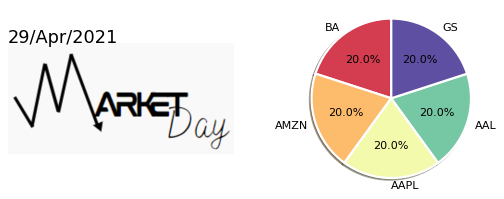

,BA,AMZN,AAPL,AAL,GS
Particiones,20.000%,20.000%,20.000%,20.000%,20.000%
Precio Cierre,235.940,3471.310,133.480,21.300,352.970
Rendimiento,0.204%,0.370%,-0.075%,-1.861%,1.386%
Media,-0.001,0.001,0.002,-0.001,0.001
Desviacion estándar,0.039,0.019,0.023,0.046,0.024
Mínimo,-0.272,-0.083,-0.138,-0.291,-0.136
Máximo,0.218,0.076,0.113,0.344,0.162
Cantidad,585.000,585.000,585.000,585.000,585.000


<IPython.core.display.Javascript object>

In [19]:
#@title ##<font color='blue'> **¡Observa los resultados!** </font> { run: "auto" }

tb = wg.TabBar(["Composición", "VaR Individual", "VaR Portafolio", 
                "Comparaciones"])
v = VENTANA(M)

with tb.output_to(1):
  v.VarIndividual()

with tb.output_to(2):
  v.VarPortafolio()

with tb.output_to(3):
  v.comparaciones()

with tb.output_to(0):
  v.composicion()